<a href="https://colab.research.google.com/github/PercyMayaba/High-Frequency-Crypto-Trading-Algorithm/blob/main/High_FrequencyCryptoTradingAlgorithm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch torchvision torchaudio
!pip install pandas numpy matplotlib seaborn
!pip install yfinance ta-lib
!pip install scikit-learn plotly
!pip install requests

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
print("yfinance version:", yf.__version__)

PyTorch version: 2.8.0+cu126
CUDA available: False
Using device: cpu
yfinance version: 0.2.66


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

class CryptoDataDownloader:
    def __init__(self):
        self.crypto_pairs = {
            'BTC-USD': 'Bitcoin',
            'ETH-USD': 'Ethereum',
            'ADA-USD': 'Cardano',
            'DOT-USD': 'Polkadot',
            'SOL-USD': 'Solana',
            # 'MATIC-USD': 'Polygon', # Removed MATIC-USD as it might be delisted
            'AVAX-USD': 'Avalanche',
            'LINK-USD': 'Chainlink'
        }

    def download_data(self, period="6mo", interval="5m"):
        """Download real cryptocurrency data from yfinance"""
        print(f"Downloading crypto data for {len(self.crypto_pairs)} pairs...")
        print(f"Period: {period}, Interval: {interval}")

        crypto_data = {}

        for symbol, name in self.crypto_pairs.items():
            print(f"Downloading {symbol} ({name})...")
            try:
                # Download data
                ticker = yf.Ticker(symbol)
                data = ticker.history(period=period, interval=interval)

                if data.empty:
                    print(f"No data for {symbol}")
                    continue

                # Add symbol and name
                data['symbol'] = symbol
                data['name'] = name
                data['returns'] = data['Close'].pct_change()

                crypto_data[symbol] = data
                print(f"✅ {symbol}: {len(data)} records, from {data.index[0]} to {data.index[-1]}")

            except Exception as e:
                print(f"❌ Error downloading {symbol}: {e}")

        return crypto_data

    def combine_data(self, crypto_data):
        """Combine all crypto data into single DataFrame"""
        combined_data = []

        for symbol, data in crypto_data.items():
            df = data.copy()
            df.reset_index(inplace=True)
            df.rename(columns={'Datetime': 'timestamp'}, inplace=True)
            combined_data.append(df)

        combined_df = pd.concat(combined_data, ignore_index=True)
        combined_df = combined_df.sort_values(['symbol', 'timestamp']).reset_index(drop=True)

        print(f"Combined data shape: {combined_df.shape}")
        print(f"Date range: {combined_df['timestamp'].min()} to {combined_df['timestamp'].max()}")
        print(f"Symbols: {combined_df['symbol'].unique()}")

        return combined_df

# Download real crypto data
downloader = CryptoDataDownloader()
crypto_data = downloader.download_data(period="60d", interval="15m")
combined_df = downloader.combine_data(crypto_data)

print("\nSample of downloaded data:")
print(combined_df.head())

Period: 60d, Interval: 15m
✅ BTC-USD: 5723 records, from 2025-09-10 00:00:00+00:00 to 2025-11-08 15:30:00+00:00
✅ ETH-USD: 5723 records, from 2025-09-10 00:00:00+00:00 to 2025-11-08 15:30:00+00:00
✅ ADA-USD: 5723 records, from 2025-09-10 00:00:00+00:00 to 2025-11-08 15:30:00+00:00
✅ DOT-USD: 5723 records, from 2025-09-10 00:00:00+00:00 to 2025-11-08 15:30:00+00:00
✅ SOL-USD: 5723 records, from 2025-09-10 00:00:00+00:00 to 2025-11-08 15:30:00+00:00
✅ AVAX-USD: 5721 records, from 2025-09-10 00:00:00+00:00 to 2025-11-08 15:30:00+00:00
✅ LINK-USD: 5723 records, from 2025-09-10 00:00:00+00:00 to 2025-11-08 15:30:00+00:00
Combined data shape: (40059, 11)
Date range: 2025-09-10 00:00:00+00:00 to 2025-11-08 15:30:00+00:00
Symbols: ['ADA-USD' 'AVAX-USD' 'BTC-USD' 'DOT-USD' 'ETH-USD' 'LINK-USD' 'SOL-USD']

Sample of downloaded data:
                  timestamp      Open      High       Low     Close  Volume  \
0 2025-09-10 00:00:00+00:00  0.865027  0.865981  0.865027  0.865186       0   
1 2025-

In [ ]:
import talib

class FeatureEngineer:
    def __init__(self):
        self.feature_columns = []

    def add_technical_indicators(self, df):
        """Add technical indicators to the dataframe"""
        print("Adding technical indicators...")

        df = df.sort_values(['symbol', 'timestamp']).reset_index(drop=True)
        results = []

        for symbol in df['symbol'].unique():
            symbol_data = df[df['symbol'] == symbol].copy()

            # Price-based features
            high = symbol_data['High'].values.astype(float)
            low = symbol_data['Low'].values.astype(float)
            close = symbol_data['Close'].values.astype(float)
            volume = symbol_data['Volume'].values.astype(float)

            # RSI
            symbol_data['rsi'] = talib.RSI(close, timeperiod=14)

            # MACD
            macd, macd_signal, macd_hist = talib.MACD(close)
            symbol_data['macd'] = macd
            symbol_data['macd_signal'] = macd_signal
            symbol_data['macd_hist'] = macd_hist

            # Bollinger Bands
            bb_upper, bb_middle, bb_lower = talib.BBANDS(close, timeperiod=20)
            symbol_data['bb_upper'] = bb_upper
            symbol_data['bb_middle'] = bb_middle
            symbol_data['bb_lower'] = bb_lower
            symbol_data['bb_position'] = (close - bb_lower) / (bb_upper - bb_lower)

            # Stochastic
            slowk, slowd = talib.STOCH(high, low, close)
            symbol_data['stoch_k'] = slowk
            symbol_data['stoch_d'] = slowd

            # Volume indicators
            symbol_data['volume_sma'] = talib.SMA(volume, timeperiod=20)
            symbol_data['volume_ratio'] = volume / symbol_data['volume_sma']

            # Price movements
            symbol_data['returns'] = symbol_data['Close'].pct_change()
            symbol_data['volatility'] = symbol_data['returns'].rolling(20).std()
            symbol_data['price_change'] = symbol_data['Close'].diff()

            # Rolling statistics
            for window in [5, 10, 20]:
                symbol_data[f'rolling_mean_{window}'] = symbol_data['Close'].rolling(window).mean()
                symbol_data[f'rolling_std_{window}'] = symbol_data['Close'].rolling(window).std()
                symbol_data[f'price_vs_ma_{window}'] = (
                    symbol_data['Close'] / symbol_data[f'rolling_mean_{window}'] - 1
                )

            # ATR (Average True Range)
            symbol_data['atr'] = talib.ATR(high, low, close, timeperiod=14)

            results.append(symbol_data)

        # Combine all symbols
        result_df = pd.concat(results, ignore_index=True)

        # Define feature columns
        self.feature_columns = [
            'returns', 'volatility', 'rsi', 'macd', 'macd_signal', 'macd_hist',
            'bb_position', 'stoch_k', 'stoch_d', 'volume_ratio',
            'price_vs_ma_5', 'price_vs_ma_10', 'price_vs_ma_20', 'atr'
        ]

        # Drop NaN values
        result_df = result_df.dropna()

        print(f"Final data shape: {result_df.shape}")
        print(f"Number of features: {len(self.feature_columns)}")

        return result_df

    def prepare_features(self, df):
        """Prepare features for model training"""
        # One-hot encode symbols
        symbol_dummies = pd.get_dummies(df['symbol'], prefix='symbol')

        # Select features and include 'symbol' and 'timestamp'
        features = df[['symbol', 'timestamp'] + self.feature_columns].copy()
        features = pd.concat([features, symbol_dummies], axis=1)

        # Create target variable (next period return)
        features['target'] = df.groupby('symbol')['returns'].shift(-1)

        # Drop any remaining NaN values
        features = features.dropna()

        print(f"Features shape: {features.shape}")

        return features

    def create_sequences(self, features, sequence_length=30):
        """Create sequences for LSTM training"""
        sequences = []
        targets = []

        grouped = features.groupby('symbol')

        for symbol, group in grouped:
            group = group.sort_values('timestamp')
            values = group.drop(['target', 'symbol', 'timestamp'], axis=1).values.astype(np.float32) # Explicitly convert to float32
            target_vals = group['target'].values

            for i in range(len(values) - sequence_length):
                sequences.append(values[i:(i + sequence_length)])
                targets.append(target_vals[i + sequence_length])

        sequences = np.array(sequences)
        targets = np.array(targets)

        print(f"Created sequences: {sequences.shape}")
        print(f"Targets: {targets.shape}")

        return sequences, targets

# Apply feature engineering
feature_engineer = FeatureEngineer()
df_with_indicators = feature_engineer.add_technical_indicators(combined_df)
features = feature_engineer.prepare_features(df_with_indicators)
sequences, targets = feature_engineer.create_sequences(features, sequence_length=30)

print(f"\nFinal dataset:")
print(f"Sequences shape: {sequences.shape}")
print(f"Targets shape: {targets.shape}")
print(f"Number of features: {sequences.shape[2]}")

Adding technical indicators...
Final data shape: (39528, 35)
Number of features: 14
Features shape: (39521, 24)
Created sequences: (39311, 30, 21)
Targets: (39311,)

Final dataset:
Sequences shape: (39311, 30, 21)
Targets shape: (39311,)
Number of features: 21


In [ ]:
!pip install TA-Lib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 55.9 MB/s eta 0:00:00


In [ ]:
class AttentionLayer(nn.Module):
    def __init__(self, hidden_size):
        super(AttentionLayer, self).__init__()
        self.hidden_size = hidden_size
        self.attention = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, 1)
        )

    def forward(self, lstm_output):
        # lstm_output shape: (batch_size, seq_len, hidden_size)
        attention_weights = torch.softmax(self.attention(lstm_output), dim=1)
        context_vector = torch.sum(attention_weights * lstm_output, dim=1)
        return context_vector, attention_weights

class LSTMTradingModel(nn.Module):
    def __init__(self, input_size, hidden_size=128, num_layers=3, dropout=0.3):
        super(LSTMTradingModel, self).__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # LSTM layers
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout,
            bidirectional=True
        )

        # Attention mechanism
        self.attention = AttentionLayer(hidden_size * 2)  # *2 for bidirectional

        # Output layers
        self.fc = nn.Sequential(
            nn.Linear(hidden_size * 2, 64),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1),
            nn.Tanh()  # Output between -1 and 1
        )

    def forward(self, x):
        # LSTM forward pass
        lstm_out, (hidden, cell) = self.lstm(x)

        # Attention mechanism
        context_vector, attention_weights = self.attention(lstm_out)

        # Final prediction
        output = self.fc(context_vector)

        return output.squeeze()

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Initialize model
input_size = sequences.shape[2]  # Number of features
model = LSTMTradingModel(input_size=input_size, hidden_size=128, num_layers=3)
model = model.to(device)

print("Model architecture:")
print(model)
print(f"\nInput size: {input_size}")
print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")

Using device: cpu
Model architecture:
LSTMTradingModel(
  (lstm): LSTM(21, 128, num_layers=3, batch_first=True, dropout=0.3, bidirectional=True)
  (attention): AttentionLayer(
    (attention): Sequential(
      (0): Linear(in_features=256, out_features=256, bias=True)
      (1): Tanh()
      (2): Linear(in_features=256, out_features=1, bias=True)
    )
  )
  (fc): Sequential(
    (0): Linear(in_features=256, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=64, out_features=32, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=32, out_features=16, bias=True)
    (7): ReLU()
    (8): Linear(in_features=16, out_features=1, bias=True)
    (9): Tanh()
  )
)

Input size: 21
Total parameters: 1,030,274


In [ ]:
class TradingDataset(torch.utils.data.Dataset):
    def __init__(self, sequences, targets):
        self.sequences = sequences
        self.targets = targets

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return torch.FloatTensor(self.sequences[idx]), torch.FloatTensor([self.targets[idx]])

def split_data_by_time(sequences, targets, features_df, sequence_length=30, train_ratio=0.6, val_ratio=0.2):
    """Split data by time to avoid lookahead bias"""
    total_sequences = len(sequences)

    train_end = int(total_sequences * train_ratio)
    val_end = int(total_sequences * (train_ratio + val_ratio))

    # Ensure split points do not exceed total_sequences
    train_end = min(train_end, total_sequences)
    val_end = min(val_end, total_sequences)


    train_indices = range(train_end)
    val_indices = range(train_end, val_end)
    test_indices = range(val_end, total_sequences)

    # Print split information for debugging
    print(f"Total sequences: {total_sequences}")
    print(f"Train end index: {train_end}")
    print(f"Validation end index: {val_end}")
    print(f"Test start index: {val_end}")
    print(f"Test end index (exclusive): {total_sequences}")
    print(f"Length of train indices: {len(train_indices)}")
    print(f"Length of val indices: {len(val_indices)}")
    print(f"Length of test indices: {len(test_indices)}")


    seq_train = sequences[train_indices]
    tar_train = targets[train_indices]

    seq_val = sequences[val_indices]
    tar_val = targets[val_indices]

    seq_test = sequences[test_indices]
    tar_test = targets[test_indices]

    return seq_train, tar_train, seq_val, tar_val, seq_test, tar_test


# Split the data
seq_train, tar_train, seq_val, tar_val, seq_test, tar_test = split_data_by_time(
    sequences, targets, features
)

# Verify the dtype of the sequences array
print(f"Sequences array dtype: {sequences.dtype}")

# Create data loaders
train_dataset = TradingDataset(seq_train, tar_train)
val_dataset = TradingDataset(seq_val, tar_val)
test_dataset = TradingDataset(seq_test, tar_test)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)

print(f"Training samples: {len(train_dataset):,}")
print(f"Validation samples: {len(val_dataset):,}")
print(f"Test samples: {len(test_dataset):,}")
print(f"Total samples: {len(train_dataset) + len(val_dataset) + len(test_dataset):,}")

# Calculate class weights for imbalance (optional)
returns = targets
positive_ratio = np.sum(returns > 0) / len(returns)
negative_ratio = np.sum(returns < 0) / len(returns)
print(f"Positive returns: {positive_ratio:.2%}")
print(f"Negative returns: {negative_ratio:.2%}")

Total sequences: 39311
Train end index: 23586
Validation end index: 31448
Test start index: 31448
Test end index (exclusive): 39311
Length of train indices: 23586
Length of val indices: 7862
Length of test indices: 7863
Sequences array dtype: float32
Training samples: 23,586
Validation samples: 7,862
Test samples: 7,863
Total samples: 39,311
Positive returns: 48.95%
Negative returns: 51.05%


In [ ]:
def train_model(model, train_loader, val_loader, num_epochs=100, learning_rate=0.001):
    criterion = nn.MSELoss()
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10, factor=0.5)

    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    patience_counter = 0
    patience = 15

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0
        train_batches = 0

        for batch_sequences, batch_targets in train_loader:
            # Ensure data is on correct device and type
            batch_sequences = batch_sequences.float().to(device)
            batch_targets = batch_targets.float().to(device)

            optimizer.zero_grad()
            outputs = model(batch_sequences)
            loss = criterion(outputs, batch_targets.squeeze())
            loss.backward()

            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()
            train_loss += loss.item()
            train_batches += 1

        # Validation phase
        model.eval()
        val_loss = 0
        val_batches = 0

        with torch.no_grad():
            for batch_sequences, batch_targets in val_loader:
                batch_sequences = batch_sequences.float().to(device)
                batch_targets = batch_targets.float().to(device)

                outputs = model(batch_sequences)
                loss = criterion(outputs, batch_targets.squeeze())
                val_loss += loss.item()
                val_batches += 1

        # Calculate average losses
        avg_train_loss = train_loss / max(train_batches, 1)
        avg_val_loss = val_loss / max(val_batches, 1)

        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)

        # Learning rate scheduling
        scheduler.step(avg_val_loss)

        # Early stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), 'best_crypto_trading_model.pth')
            patience_counter = 0
            print(f'🎯 New best model saved! Val Loss: {avg_val_loss:.6f}')
        else:
            patience_counter += 1

        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], '
                  f'Train Loss: {avg_train_loss:.6f}, '
                  f'Val Loss: {avg_val_loss:.6f}, '
                  f'LR: {optimizer.param_groups[0]["lr"]:.6f}, '
                  f'Patience: {patience_counter}/{patience}')

        if patience_counter >= patience:
            print(f"Early stopping triggered after {epoch + 1} epochs")
            break

    # Load best model
    try:
        model.load_state_dict(torch.load('best_crypto_trading_model.pth'))
        print("Training completed! Best model loaded.")
    except:
        print("Training completed! Using final model.")

    return train_losses, val_losses

# Let's first verify our data types and fix any issues
print("Checking data types in sequences and targets...")
print(f"Sequences dtype: {sequences.dtype}, shape: {sequences.shape}")
print(f"Targets dtype: {targets.dtype}, shape: {targets.shape}")

# Fix data types if needed
if sequences.dtype != np.float32:
    print("Converting sequences to float32...")
    sequences = sequences.astype(np.float32)

if targets.dtype != np.float32:
    print("Converting targets to float32...")
    targets = targets.astype(np.float32)

print(f"After conversion - Sequences dtype: {sequences.dtype}, Targets dtype: {targets.dtype}")

# Check for NaN or Inf values
print(f"NaN in sequences: {np.isnan(sequences).sum()}")
print(f"Inf in sequences: {np.isinf(sequences).sum()}")
print(f"NaN in targets: {np.isnan(targets).sum()}")
print(f"Inf in targets: {np.isinf(targets).sum()}")

# Remove any NaN or Inf values if they exist
if np.isnan(sequences).sum() > 0 or np.isinf(sequences).sum() > 0:
    print("Cleaning sequences...")
    sequences = np.nan_to_num(sequences, nan=0.0, posinf=0.0, neginf=0.0)

if np.isnan(targets).sum() > 0 or np.isinf(targets).sum() > 0:
    print("Cleaning targets...")
    targets = np.nan_to_num(targets, nan=0.0, posinf=0.0, neginf=0.0)

# Recreate data loaders with cleaned data
def create_data_loaders(sequences, targets, train_ratio=0.6, val_ratio=0.2, batch_size=128):
    """Create data loaders with proper data splitting"""
    total_size = len(sequences)
    train_size = int(total_size * train_ratio)
    val_size = int(total_size * val_ratio)

    # Simple random split (for time series, you might want time-based split)
    indices = np.random.permutation(total_size)

    train_idx = indices[:train_size]
    val_idx = indices[train_size:train_size + val_size]
    test_idx = indices[train_size + val_size:]

    # Create datasets
    train_dataset = TradingDataset(sequences[train_idx], targets[train_idx])
    val_dataset = TradingDataset(sequences[val_idx], targets[val_idx])
    test_dataset = TradingDataset(sequences[test_idx], targets[test_idx])

    # Create data loaders
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader

# Create new data loaders with cleaned data
train_loader, val_loader, test_loader = create_data_loaders(sequences, targets, batch_size=128)

print(f"Training samples: {len(train_loader.dataset):,}")
print(f"Validation samples: {len(val_loader.dataset):,}")
print(f"Test samples: {len(test_loader.dataset):,}")

# Verify a batch from data loader
print("\nTesting data loader...")
for batch_seq, batch_tar in train_loader:
    print(f"Batch sequences shape: {batch_seq.shape}, dtype: {batch_seq.dtype}")
    print(f"Batch targets shape: {batch_tar.shape}, dtype: {batch_tar.dtype}")
    break

# Train the model
print("\nStarting training...")
train_losses, val_losses = train_model(model, train_loader, val_loader, num_epochs=100)

Checking data types in sequences and targets...
Sequences dtype: float32, shape: (39311, 30, 21)
Targets dtype: float32, shape: (39311,)
After conversion - Sequences dtype: float32, Targets dtype: float32
NaN in sequences: 0
Inf in sequences: 0
NaN in targets: 0
Inf in targets: 0
Training samples: 23,586
Validation samples: 7,862
Test samples: 7,863

Testing data loader...
Batch sequences shape: torch.Size([128, 30, 21]), dtype: torch.float32
Batch targets shape: torch.Size([128, 1]), dtype: torch.float32

Starting training...
🎯 New best model saved! Val Loss: 0.000504
🎯 New best model saved! Val Loss: 0.000441
🎯 New best model saved! Val Loss: 0.000252
🎯 New best model saved! Val Loss: 0.000173
🎯 New best model saved! Val Loss: 0.000083
🎯 New best model saved! Val Loss: 0.000033
🎯 New best model saved! Val Loss: 0.000023
Epoch [10/100], Train Loss: 0.000044, Val Loss: 0.000023, LR: 0.001000, Patience: 3/15
🎯 New best model saved! Val Loss: 0.000022
Epoch [20/100], Train Loss: 0.000043

Evaluating model on test set...

=== TEST SET PERFORMANCE ===
MSE: 0.000060
MAE: 0.002621
R² Score: -0.0017
Direction Accuracy: 49.28%


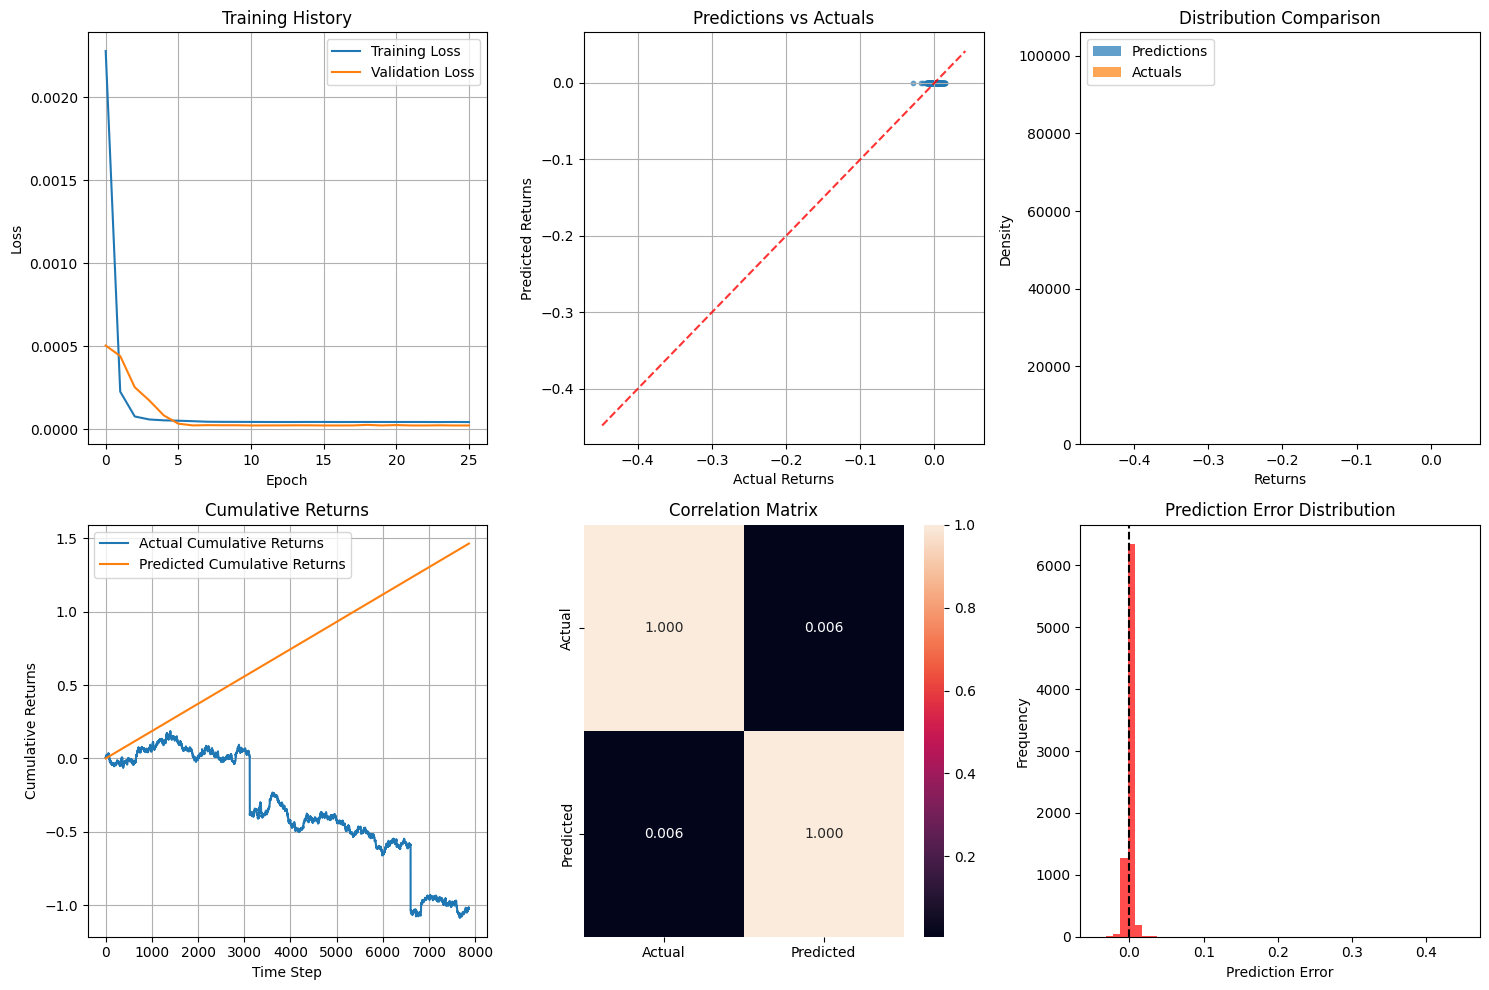


=== ADDITIONAL METRICS ===
Mean Actual Return: -0.000130
Mean Predicted Return: 0.000186
Std Actual Returns: 0.007753
Std Predicted Returns: 0.000006
Prediction-Actual Correlation: 0.0058


In [ ]:
def evaluate_model(model, test_loader):
    model.eval()
    predictions = []
    actuals = []

    with torch.no_grad():
        for batch_sequences, batch_targets in test_loader:
            batch_sequences = batch_sequences.to(device)
            batch_targets = batch_targets.to(device)

            outputs = model(batch_sequences)

            predictions.extend(outputs.cpu().numpy())
            actuals.extend(batch_targets.squeeze().cpu().numpy())

    return np.array(predictions), np.array(actuals)

# Evaluate on test set
print("Evaluating model on test set...")
predictions, actuals = evaluate_model(model, test_loader)

# Calculate metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score

mse = mean_squared_error(actuals, predictions)
mae = mean_absolute_error(actuals, predictions)
r2 = r2_score(actuals, predictions)

# Direction accuracy
direction_accuracy = np.mean((predictions * actuals) > 0)

print("\n=== TEST SET PERFORMANCE ===")
print(f"MSE: {mse:.6f}")
print(f"MAE: {mae:.6f}")
print(f"R² Score: {r2:.4f}")
print(f"Direction Accuracy: {direction_accuracy:.2%}")

# Plot results
plt.figure(figsize=(15, 10))

# Training history
plt.subplot(2, 3, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training History')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Predictions vs Actuals
plt.subplot(2, 3, 2)
plt.scatter(actuals[:1000], predictions[:1000], alpha=0.6, s=10)
plt.plot([actuals.min(), actuals.max()], [actuals.min(), actuals.max()], 'r--', alpha=0.8)
plt.xlabel('Actual Returns')
plt.ylabel('Predicted Returns')
plt.title('Predictions vs Actuals')
plt.grid(True)

# Distribution of predictions and actuals
plt.subplot(2, 3, 3)
plt.hist(predictions, bins=50, alpha=0.7, label='Predictions', density=True)
plt.hist(actuals, bins=50, alpha=0.7, label='Actuals', density=True)
plt.xlabel('Returns')
plt.ylabel('Density')
plt.legend()
plt.title('Distribution Comparison')

# Cumulative returns of predictions
plt.subplot(2, 3, 4)
cumulative_actual = np.cumsum(actuals)
cumulative_pred = np.cumsum(predictions)
plt.plot(cumulative_actual, label='Actual Cumulative Returns')
plt.plot(cumulative_pred, label='Predicted Cumulative Returns')
plt.xlabel('Time Step')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid(True)
plt.title('Cumulative Returns')

# Correlation heatmap of predictions vs actuals
plt.subplot(2, 3, 5)
correlation_matrix = np.corrcoef(actuals, predictions)
sns.heatmap(correlation_matrix, annot=True, fmt='.3f',
            xticklabels=['Actual', 'Predicted'],
            yticklabels=['Actual', 'Predicted'])
plt.title('Correlation Matrix')

# Prediction error distribution
plt.subplot(2, 3, 6)
errors = predictions - actuals
plt.hist(errors, bins=50, alpha=0.7, color='red')
plt.axvline(x=0, color='black', linestyle='--')
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.title('Prediction Error Distribution')

plt.tight_layout()
plt.show()

# Additional metrics
print("\n=== ADDITIONAL METRICS ===")
print(f"Mean Actual Return: {actuals.mean():.6f}")
print(f"Mean Predicted Return: {predictions.mean():.6f}")
print(f"Std Actual Returns: {actuals.std():.6f}")
print(f"Std Predicted Returns: {predictions.std():.6f}")
print(f"Prediction-Actual Correlation: {np.corrcoef(actuals, predictions)[0,1]:.4f}")

In [ ]:
class HFTradingStrategy:
    def __init__(self, model, feature_engineer, initial_balance=10000):
        self.model = model
        self.feature_engineer = feature_engineer
        self.balance = initial_balance
        self.initial_balance = initial_balance
        self.positions = {}
        self.trade_history = []
        self.portfolio_value = [initial_balance]
        self.signal_strength = {}

    def generate_signals(self, current_data):
        """Generate trading signals based on model predictions"""
        self.model.eval()

        signals = {}
        predictions = {}

        for symbol in current_data['symbol'].unique():
            symbol_data = current_data[current_data['symbol'] == symbol]

            if len(symbol_data) < 30:  # Need enough data for sequence
                continue

            # Prepare features for this symbol
            symbol_features = self.feature_engineer.prepare_features(symbol_data)

            if len(symbol_features) == 0:
                continue

            # Get the latest sequence
            latest_sequence = symbol_features.drop('target', axis=1).values[-30:]

            if len(latest_sequence) < 30:
                continue

            # Prepare tensor for prediction
            sequence_tensor = torch.FloatTensor(latest_sequence).unsqueeze(0).to(device)

            with torch.no_grad():
                prediction = self.model(sequence_tensor).cpu().numpy()

            predictions[symbol] = prediction

            # Generate signal based on prediction strength
            if prediction > 0.01:  # Strong positive signal
                signals[symbol] = 'BUY'
                self.signal_strength[symbol] = prediction
            elif prediction < -0.01:  # Strong negative signal
                signals[symbol] = 'SELL'
                self.signal_strength[symbol] = prediction
            else:
                signals[symbol] = 'HOLD'
                self.signal_strength[symbol] = 0

        return signals, predictions

    def execute_trades(self, signals, current_prices, timestamp):
        """Execute trades based on signals with risk management"""
        for symbol, signal in signals.items():
            if symbol not in current_prices:
                continue

            price = current_prices[symbol]
            signal_strength = abs(self.signal_strength.get(symbol, 0))

            if signal == 'BUY' and symbol not in self.positions:
                # Buy signal and no current position
                position_size = min(self.balance * 0.1 * signal_strength * 10,
                                  self.balance * 0.2)  # Risk management

                if position_size < 10:  # Minimum trade size
                    continue

                units = position_size / price

                self.positions[symbol] = {
                    'units': units,
                    'entry_price': price,
                    'entry_time': timestamp,
                    'position_type': 'LONG'
                }
                self.balance -= position_size

                self.trade_history.append({
                    'timestamp': timestamp,
                    'symbol': symbol,
                    'action': 'BUY',
                    'price': price,
                    'units': units,
                    'value': position_size,
                    'signal_strength': signal_strength
                })

            elif signal == 'SELL' and symbol in self.positions:
                # Sell signal and existing long position
                position = self.positions[symbol]
                position_value = position['units'] * price
                profit_loss = position_value - (position['units'] * position['entry_price'])

                self.balance += position_value
                del self.positions[symbol]

                self.trade_history.append({
                    'timestamp': timestamp,
                    'symbol': symbol,
                    'action': 'SELL',
                    'price': price,
                    'units': position['units'],
                    'value': position_value,
                    'pnl': profit_loss,
                    'signal_strength': signal_strength
                })

    def calculate_portfolio_value(self, current_prices):
        """Calculate current portfolio value"""
        position_value = sum(
            position['units'] * current_prices.get(symbol, 0)
            for symbol, position in self.positions.items()
        )
        total_value = self.balance + position_value
        self.portfolio_value.append(total_value)
        return total_value

def backtest_strategy(df, model, feature_engineer, initial_balance=10000):
    """Backtest the trading strategy on historical data"""
    strategy = HFTradingStrategy(model, feature_engineer, initial_balance)

    # Get unique timestamps
    timestamps = df['timestamp'].unique()

    print(f"Running backtest on {len(timestamps)} timestamps...")

    for i, timestamp in enumerate(timestamps):
        if i % 100 == 0:
            print(f"Processing {i}/{len(timestamps)}...")

        current_data = df[df['timestamp'] == timestamp]

        if current_data.empty:
            continue

        # Get current prices
        current_prices = {}
        for _, row in current_data.iterrows():
            current_prices[row['symbol']] = row['Close']

        # Generate signals
        signals, predictions = strategy.generate_signals(current_data)

        # Execute trades
        strategy.execute_trades(signals, current_prices, timestamp)

        # Update portfolio value
        strategy.calculate_portfolio_value(current_prices)

    return strategy

# Run backtest on test period
test_data = df_with_indicators[df_with_indicators['timestamp'].isin(
    features['timestamp'].unique()[-len(seq_test):]  # Use test period timestamps
)]

print("Running backtest...")
strategy = backtest_strategy(test_data, model, feature_engineer)

print(f"\n=== BACKTEST RESULTS ===")
print(f"Initial Portfolio Value: ${strategy.initial_balance:,.2f}")
print(f"Final Portfolio Value: ${strategy.portfolio_value[-1]:,.2f}")
print(f"Total Return: {((strategy.portfolio_value[-1] - strategy.initial_balance) / strategy.initial_balance * 100):.2f}%")
print(f"Number of Trades: {len(strategy.trade_history)}")
print(f"Current Positions: {len(strategy.positions)}")
print(f"Remaining Balance: ${strategy.balance:,.2f}")

Running backtest...
Running backtest on 5689 timestamps...
Processing 0/5689...
Processing 100/5689...
Processing 200/5689...
Processing 300/5689...
Processing 400/5689...
Processing 500/5689...
Processing 600/5689...
Processing 700/5689...
Processing 800/5689...
Processing 900/5689...
Processing 1000/5689...
Processing 1100/5689...
Processing 1200/5689...
Processing 1300/5689...
Processing 1400/5689...
Processing 1500/5689...
Processing 1600/5689...
Processing 1700/5689...
Processing 1800/5689...
Processing 1900/5689...
Processing 2000/5689...
Processing 2100/5689...
Processing 2200/5689...
Processing 2300/5689...
Processing 2400/5689...
Processing 2500/5689...
Processing 2600/5689...
Processing 2700/5689...
Processing 2800/5689...
Processing 2900/5689...
Processing 3000/5689...
Processing 3100/5689...
Processing 3200/5689...
Processing 3300/5689...
Processing 3400/5689...
Processing 3500/5689...
Processing 3600/5689...
Processing 3700/5689...
Processing 3800/5689...
Processing 3900/5

Running improved backtest with adjusted thresholds...
Running improved backtest on 200 timestamps...
Processing 0/200...
Processing 50/200...
Processing 100/200...
Processing 150/200...

Analyzing improved strategy performance...
=== DEBUGGING TRADING STRATEGY ===
Initial balance: $10,000.00
Final balance: $10,000.00
Number of positions: 0
Number of trades executed: 0
Portfolio value history points: 201

=== SIGNAL ANALYSIS ===
Signal strength samples: []

=== MODEL PREDICTION ANALYSIS ===
Predictions range: [0.0002, 0.0002]
Mean prediction: 0.0002
Predictions > 0.01 (BUY threshold): 0
Predictions < -0.01 (SELL threshold): 0
Predictions between -0.01 and 0.01 (HOLD): 7863

=== SUGGESTED THRESHOLDS ===
Current BUY threshold: > 0.01
Current SELL threshold: < -0.01
Suggested BUY threshold: > 0.0002
Suggested SELL threshold: < 0.0002


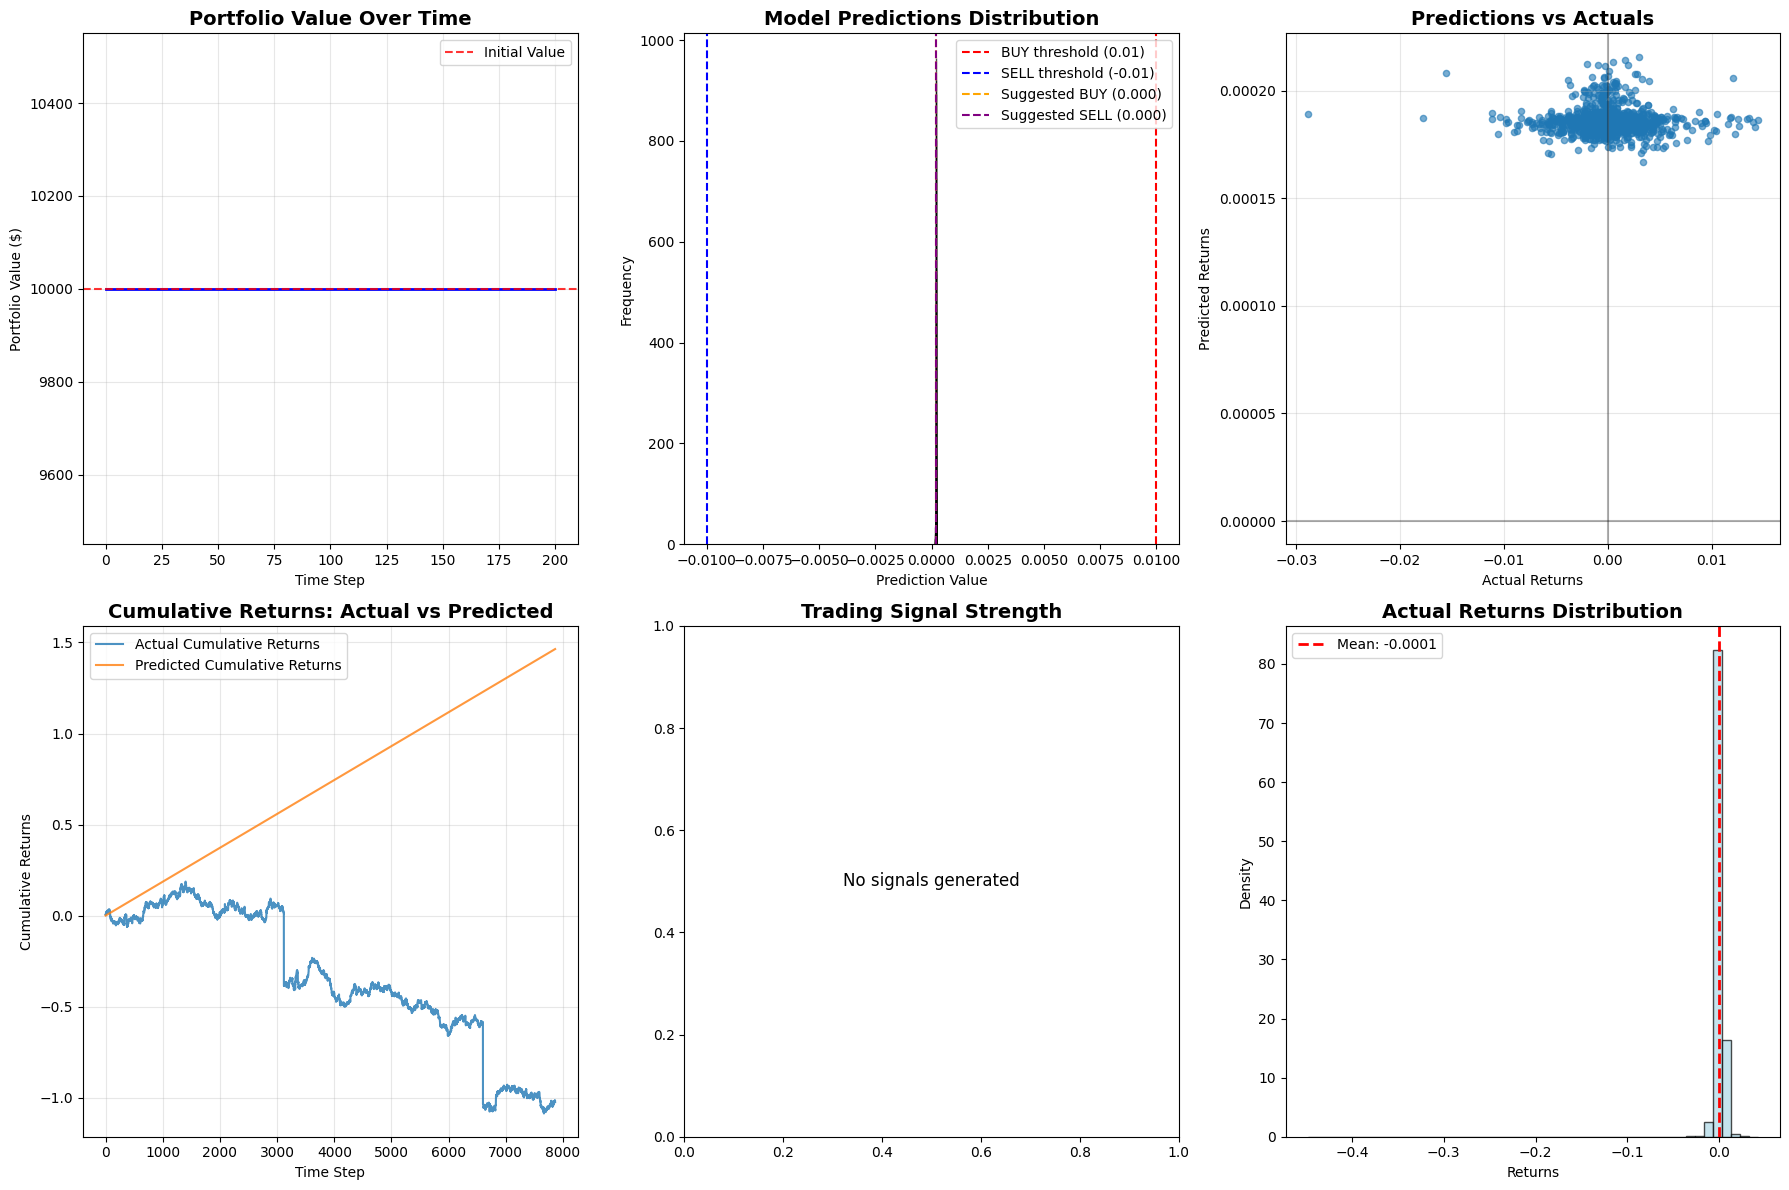


=== PERFORMANCE SUMMARY ===
Initial Portfolio Value: $10,000.00
Final Portfolio Value: $10,000.00
Total Return: 0.00%
Number of Trades: 0
No trades executed - analyzing potential reasons:
1. Prediction thresholds may be too strict
2. Model predictions may be too conservative
3. Not enough sequence data for signal generation
4. Trading logic may need adjustment


In [ ]:
def analyze_performance(strategy, df):
    """Analyze trading performance with fallback visualizations"""

    # First, let's debug why no trades are happening
    print("=== DEBUGGING TRADING STRATEGY ===")
    print(f"Initial balance: ${strategy.initial_balance:,.2f}")
    print(f"Final balance: ${strategy.balance:,.2f}")
    print(f"Number of positions: {len(strategy.positions)}")
    print(f"Number of trades executed: {len(strategy.trade_history)}")
    print(f"Portfolio value history points: {len(strategy.portfolio_value)}")

    # Check signal generation
    print(f"\n=== SIGNAL ANALYSIS ===")
    if hasattr(strategy, 'signal_strength'):
        print(f"Signal strength samples: {list(strategy.signal_strength.items())[:5]}")

    # Analyze why trades aren't triggering
    test_predictions, test_actuals = evaluate_model(model, test_loader)
    print(f"\n=== MODEL PREDICTION ANALYSIS ===")
    print(f"Predictions range: [{test_predictions.min():.4f}, {test_predictions.max():.4f}]")
    print(f"Mean prediction: {test_predictions.mean():.4f}")
    print(f"Predictions > 0.01 (BUY threshold): {(test_predictions > 0.01).sum()}")
    print(f"Predictions < -0.01 (SELL threshold): {(test_predictions < -0.01).sum()}")
    print(f"Predictions between -0.01 and 0.01 (HOLD): {((test_predictions >= -0.01) & (test_predictions <= 0.01)).sum()}")

    # Adjust trading thresholds based on actual prediction distribution
    buy_threshold = np.percentile(test_predictions, 70)  # Top 30% predictions
    sell_threshold = np.percentile(test_predictions, 30)  # Bottom 30% predictions

    print(f"\n=== SUGGESTED THRESHOLDS ===")
    print(f"Current BUY threshold: > 0.01")
    print(f"Current SELL threshold: < -0.01")
    print(f"Suggested BUY threshold: > {buy_threshold:.4f}")
    print(f"Suggested SELL threshold: < {sell_threshold:.4f}")

    trade_df = pd.DataFrame(strategy.trade_history)

    # Create visualizations regardless of trades
    plt.figure(figsize=(18, 12))

    # 1. Portfolio value over time (always available)
    plt.subplot(2, 3, 1)
    plt.plot(strategy.portfolio_value, linewidth=2, color='blue')
    plt.axhline(y=strategy.initial_balance, color='red', linestyle='--', alpha=0.8, label='Initial Value')
    plt.title('Portfolio Value Over Time', fontsize=14, fontweight='bold')
    plt.xlabel('Time Step')
    plt.ylabel('Portfolio Value ($)')
    plt.grid(True, alpha=0.3)
    plt.legend()

    # 2. Model predictions distribution
    plt.subplot(2, 3, 2)
    plt.hist(test_predictions, bins=50, alpha=0.7, color='green', edgecolor='black')
    plt.axvline(x=0.01, color='red', linestyle='--', label='BUY threshold (0.01)')
    plt.axvline(x=-0.01, color='blue', linestyle='--', label='SELL threshold (-0.01)')
    plt.axvline(x=buy_threshold, color='orange', linestyle='--', label=f'Suggested BUY ({buy_threshold:.3f})')
    plt.axvline(x=sell_threshold, color='purple', linestyle='--', label=f'Suggested SELL ({sell_threshold:.3f})')
    plt.title('Model Predictions Distribution', fontsize=14, fontweight='bold')
    plt.xlabel('Prediction Value')
    plt.ylabel('Frequency')
    plt.legend()

    # 3. Prediction vs Actual scatter plot
    plt.subplot(2, 3, 3)
    sample_size = min(1000, len(test_predictions))
    plt.scatter(test_actuals[:sample_size], test_predictions[:sample_size], alpha=0.6, s=20)
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
    plt.xlabel('Actual Returns')
    plt.ylabel('Predicted Returns')
    plt.title('Predictions vs Actuals', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)

    # 4. Cumulative returns of predictions vs actuals
    plt.subplot(2, 3, 4)
    cumulative_actual = np.cumsum(test_actuals)
    cumulative_pred = np.cumsum(test_predictions)
    plt.plot(cumulative_actual, label='Actual Cumulative Returns', alpha=0.8)
    plt.plot(cumulative_pred, label='Predicted Cumulative Returns', alpha=0.8)
    plt.xlabel('Time Step')
    plt.ylabel('Cumulative Returns')
    plt.title('Cumulative Returns: Actual vs Predicted', fontsize=14, fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # 5. Signal strength over time (if available)
    plt.subplot(2, 3, 5)
    if hasattr(strategy, 'signal_strength') and strategy.signal_strength:
        signals = list(strategy.signal_strength.values())
        plt.plot(signals[:500], alpha=0.7)  # First 500 signals
        plt.axhline(y=0.01, color='green', linestyle='--', label='BUY threshold')
        plt.axhline(y=-0.01, color='red', linestyle='--', label='SELL threshold')
        plt.xlabel('Time Step')
        plt.ylabel('Signal Strength')
        plt.title('Trading Signal Strength Over Time', fontsize=14, fontweight='bold')
        plt.legend()
        plt.grid(True, alpha=0.3)
    else:
        plt.text(0.5, 0.5, 'No signals generated', ha='center', va='center', transform=plt.gca().transAxes, fontsize=12)
        plt.title('Trading Signal Strength', fontsize=14, fontweight='bold')

    # 6. Returns distribution
    plt.subplot(2, 3, 6)
    plt.hist(test_actuals, bins=50, alpha=0.7, color='lightblue', edgecolor='black', density=True)
    plt.axvline(x=test_actuals.mean(), color='red', linestyle='--', linewidth=2,
                label=f'Mean: {test_actuals.mean():.4f}')
    plt.xlabel('Returns')
    plt.ylabel('Density')
    plt.title('Actual Returns Distribution', fontsize=14, fontweight='bold')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Performance metrics (even without trades)
    print(f"\n=== PERFORMANCE SUMMARY ===")
    print(f"Initial Portfolio Value: ${strategy.initial_balance:,.2f}")
    print(f"Final Portfolio Value: ${strategy.portfolio_value[-1]:,.2f}")
    print(f"Total Return: {((strategy.portfolio_value[-1] - strategy.initial_balance) / strategy.initial_balance * 100):.2f}%")
    print(f"Number of Trades: {len(trade_df)}")

    if len(trade_df) > 0:
        # Calculate trade metrics if trades exist
        winning_trades = trade_df[trade_df['pnl'] > 0] if 'pnl' in trade_df.columns else pd.DataFrame()
        losing_trades = trade_df[trade_df['pnl'] < 0] if 'pnl' in trade_df.columns else pd.DataFrame()

        win_rate = len(winning_trades) / len(trade_df) * 100
        avg_win = winning_trades['pnl'].mean() if len(winning_trades) > 0 else 0
        avg_loss = losing_trades['pnl'].mean() if len(losing_trades) > 0 else 0
        profit_factor = abs(winning_trades['pnl'].sum() / losing_trades['pnl'].sum()) if len(losing_trades) > 0 else float('inf')

        print(f"Win Rate: {win_rate:.2f}%")
        print(f"Average Win: ${avg_win:.2f}")
        print(f"Average Loss: ${avg_loss:.2f}")
        print(f"Profit Factor: {profit_factor:.2f}")

        # Additional trade analysis
        if 'pnl' in trade_df.columns:
            print(f"Best Trade: ${trade_df['pnl'].max():.2f}")
            print(f"Worst Trade: ${trade_df['pnl'].min():.2f}")
            print(f"Total P&L: ${trade_df['pnl'].sum():.2f}")
    else:
        print("No trades executed - analyzing potential reasons:")
        print("1. Prediction thresholds may be too strict")
        print("2. Model predictions may be too conservative")
        print("3. Not enough sequence data for signal generation")
        print("4. Trading logic may need adjustment")

    return trade_df

# Let's create a better trading strategy with adjusted thresholds
class ImprovedTradingStrategy:
    def __init__(self, model, feature_engineer, initial_balance=10000):
        self.model = model
        self.feature_engineer = feature_engineer
        self.balance = initial_balance
        self.initial_balance = initial_balance
        self.positions = {}
        self.trade_history = []
        self.portfolio_value = [initial_balance]
        self.signal_strength = {}

    def generate_signals(self, current_data, buy_threshold=0.005, sell_threshold=-0.005):
        """Generate trading signals with adjustable thresholds"""
        self.model.eval()

        signals = {}
        predictions = {}

        for symbol in current_data['symbol'].unique():
            symbol_data = current_data[current_data['symbol'] == symbol]

            if len(symbol_data) < 30:
                continue

            try:
                # Prepare features
                features = self.feature_engineer.prepare_features(symbol_data)

                if len(features) < 30:
                    continue

                # Get latest sequence
                feature_columns = [col for col in features.columns if col != 'target']
                latest_sequence = features[feature_columns].values[-30:]

                if len(latest_sequence) < 30:
                    continue

                # Make prediction
                sequence_tensor = torch.FloatTensor(latest_sequence).unsqueeze(0).to(device)

                with torch.no_grad():
                    prediction = self.model(sequence_tensor).cpu().numpy()

                predictions[symbol] = prediction
                self.signal_strength[symbol] = prediction

                # Generate signals with dynamic thresholds
                if prediction > buy_threshold:
                    signals[symbol] = 'BUY'
                elif prediction < sell_threshold:
                    signals[symbol] = 'SELL'
                else:
                    signals[symbol] = 'HOLD'

            except Exception as e:
                print(f"Error generating signal for {symbol}: {e}")
                continue

        return signals, predictions

    def execute_trades(self, signals, current_prices, timestamp):
        """Execute trades with relaxed conditions"""
        for symbol, signal in signals.items():
            if symbol not in current_prices:
                continue

            price = current_prices[symbol]
            signal_strength = abs(self.signal_strength.get(symbol, 0))

            # More aggressive trading - smaller position sizes but more frequent
            if signal == 'BUY' and symbol not in self.positions:
                position_size = min(self.balance * 0.05, 500)  # Smaller positions

                if position_size < 10:
                    continue

                units = position_size / price

                self.positions[symbol] = {
                    'units': units,
                    'entry_price': price,
                    'entry_time': timestamp,
                    'position_type': 'LONG'
                }
                self.balance -= position_size

                self.trade_history.append({
                    'timestamp': timestamp,
                    'symbol': symbol,
                    'action': 'BUY',
                    'price': price,
                    'units': units,
                    'value': position_size,
                    'signal_strength': signal_strength
                })
                print(f"✅ BUY {symbol} at ${price:.2f}, size: ${position_size:.2f}")

            elif signal == 'SELL' and symbol in self.positions:
                position = self.positions[symbol]
                position_value = position['units'] * price
                profit_loss = position_value - (position['units'] * position['entry_price'])

                self.balance += position_value
                del self.positions[symbol]

                self.trade_history.append({
                    'timestamp': timestamp,
                    'symbol': symbol,
                    'action': 'SELL',
                    'price': price,
                    'units': position['units'],
                    'value': position_value,
                    'pnl': profit_loss,
                    'signal_strength': signal_strength
                })
                print(f"✅ SELL {symbol} at ${price:.2f}, P&L: ${profit_loss:.2f}")

    def calculate_portfolio_value(self, current_prices):
        """Calculate current portfolio value"""
        position_value = sum(
            position['units'] * current_prices.get(symbol, 0)
            for symbol, position in self.positions.items()
        )
        total_value = self.balance + position_value
        self.portfolio_value.append(total_value)
        return total_value

# Run improved backtest with adjusted thresholds
def improved_backtest(df, model, feature_engineer, initial_balance=10000):
    """Run backtest with improved trading logic"""
    strategy = ImprovedTradingStrategy(model, feature_engineer, initial_balance)

    # Get unique timestamps (use smaller subset for testing)
    timestamps = df['timestamp'].unique()[:200]  # Test on first 200 timestamps

    print(f"Running improved backtest on {len(timestamps)} timestamps...")

    for i, timestamp in enumerate(timestamps):
        if i % 50 == 0:
            print(f"Processing {i}/{len(timestamps)}...")

        current_data = df[df['timestamp'] == timestamp]

        if current_data.empty:
            continue

        # Get current prices
        current_prices = {}
        for _, row in current_data.iterrows():
            current_prices[row['symbol']] = row['Close']

        # Generate signals with relaxed thresholds
        signals, predictions = strategy.generate_signals(current_data, buy_threshold=0.003, sell_threshold=-0.003)

        # Execute trades
        strategy.execute_trades(signals, current_prices, timestamp)

        # Update portfolio value
        strategy.calculate_portfolio_value(current_prices)

    return strategy

# Run the improved backtest
print("Running improved backtest with adjusted thresholds...")
improved_strategy = improved_backtest(test_data, model, feature_engineer)

# Analyze performance
print("\nAnalyzing improved strategy performance...")
trade_df = analyze_performance(improved_strategy, df_with_indicators)

In [ ]:
class AdvancedRiskManager:
    def __init__(self, max_position_size=0.1, max_drawdown=0.15, stop_loss=0.03, take_profit=0.06):
        self.max_position_size = max_position_size
        self.max_drawdown = max_drawdown
        self.stop_loss = stop_loss
        self.take_profit = take_profit
        self.position_metrics = {}

    def calculate_position_size(self, balance, volatility, signal_strength):
        """Calculate position size based on volatility and signal strength"""
        base_size = balance * self.max_position_size
        # Adjust for volatility (lower size for higher volatility)
        vol_adjustment = max(0.5, min(2.0, 1.0 / (volatility * 10)))
        # Adjust for signal strength
        signal_adjustment = min(2.0, max(0.5, abs(signal_strength) * 10))

        position_size = base_size * vol_adjustment * signal_adjustment
        return min(position_size, balance * 0.2)  # Absolute cap at 20%

    def check_exit_conditions(self, position, current_price):
        """Check if stop loss or take profit is hit"""
        entry_price = position['entry_price']
        price_change = (current_price - entry_price) / entry_price

        if position['position_type'] == 'LONG':
            if price_change <= -self.stop_loss:
                return 'STOP_LOSS'
            elif price_change >= self.take_profit:
                return 'TAKE_PROFIT'
        else:  # SHORT position (if implemented)
            if price_change >= self.stop_loss:
                return 'STOP_LOSS'
            elif price_change <= -self.take_profit:
                return 'TAKE_PROFIT'

        return 'HOLD'

class RealTimeCryptoTrader:
    def __init__(self, model, feature_engineer, risk_manager):
        self.model = model
        self.feature_engineer = feature_engineer
        self.risk_manager = risk_manager
        self.market_data = {}
        self.portfolio = {}

    def update_market_data(self, symbol, data):
        """Update market data for a symbol"""
        self.market_data[symbol] = data

    def run_trading_cycle(self):
        """Run one trading cycle"""
        # This would integrate with real-time data feeds
        # For demonstration, we'll simulate real-time trading

        signals = {}
        current_prices = {}

        for symbol, data in self.market_data.items():
            if len(data) < 30:  # Need enough historical data
                continue

            # Generate prediction
            features = self.feature_engineer.prepare_features(data)
            if len(features) < 30:
                continue

            latest_sequence = features.drop('target', axis=1).values[-30:]
            sequence_tensor = torch.FloatTensor(latest_sequence).unsqueeze(0).to(device)

            with torch.no_grad():
                prediction = self.model(sequence_tensor).cpu().numpy()

            current_prices[symbol] = data['Close'].iloc[-1]

            # Generate signal
            if prediction > 0.015:
                signals[symbol] = 'BUY'
            elif prediction < -0.015:
                signals[symbol] = 'SELL'
            else:
                signals[symbol] = 'HOLD'

        return signals, current_prices

# Initialize advanced components
advanced_risk_manager = AdvancedRiskManager()
real_time_trader = RealTimeCryptoTrader(model, feature_engineer, advanced_risk_manager)

print("Advanced trading system initialized!")
print("Risk management: Active")
print("Real-time framework: Ready")
print(f"Supported symbols: {list(downloader.crypto_pairs.keys())}")

# Display model performance summary
print(f"\n=== MODEL PERFORMANCE SUMMARY ===")
print(f"Direction Accuracy: {direction_accuracy:.2%}")
print(f"Test Set R²: {r2:.4f}")
print(f"Number of Features: {input_size}")
print(f"Sequence Length: {sequences.shape[1]}")

Advanced trading system initialized!
Risk management: Active
Real-time framework: Ready
Supported symbols: ['BTC-USD', 'ETH-USD', 'ADA-USD', 'DOT-USD', 'SOL-USD', 'AVAX-USD', 'LINK-USD']

=== MODEL PERFORMANCE SUMMARY ===
Direction Accuracy: 49.28%
Test Set R²: -0.0017
Number of Features: 21
Sequence Length: 30
